# Image Caption Generation with Google's Conceptual Caption Dataset

Conceptual Captions is a dataset containing (image-URL, caption) pairs designed for the training and evaluation of machine learned image captioning systems.

https://github.com/google-research-datasets/conceptual-captions


Automatic image captioning is the task of producing a natural-language utterance (usually a sentence) that correctly reflects the visual content of an image. Up to this point, the resource most used for this task was the MS-COCO dataset, containing around 120,000 images and 5-way image-caption annotations (produced by paid annotators).

Google's Conceptual Captions dataset has more than 3 million images, paired with natural-language captions. In contrast with the curated style of the MS-COCO images, Conceptual Captions images and their raw descriptions are harvested from the web, and therefore represent a wider variety of styles. 

The raw descriptions are harvested from the Alt-text HTML attribute associated with web images. We developed an automatic pipeline that extracts,filters, and transforms candidate image/caption pairs, with the goal of achieving a balance of cleanliness, informativeness, fluency, and learnability of the resulting captions.


This is a subset of much larger data containing links to around 3.3M images and their captions. We have downloaded 1800+ of these images for the session [from the validation set]. You can try working with larger set and see if that gives better results 


In [ ]:
%tensorflow_version 2.x

## Download the Training Images

In [ ]:
!wget https://www.dropbox.com/s/2z3x3j0whlmnq98/images.zip

--2020-02-16 03:45:40--  https://www.dropbox.com/s/2z3x3j0whlmnq98/images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2z3x3j0whlmnq98/images.zip [following]
--2020-02-16 03:45:40--  https://www.dropbox.com/s/raw/2z3x3j0whlmnq98/images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1d83daf03e1766a68d081c8a05.dl.dropboxusercontent.com/cd/0/inline/AyMMHabXcvXKrhVioht9Eg8s0BJbboDP8etL5tUHl9wnWFHO6A3pOJ4gl8KHTHx8d3_d8S5am2V1zr-2GTTpN0orAjw9yQ3VRS36ux2pMQR_X-OVvojsjZ03L0ydDB1B4h0/file# [following]
--2020-02-16 03:45:40--  https://uc1d83daf03e1766a68d081c8a05.dl.dropboxusercontent.com/cd/0/inline/AyMMHabXcvXKrhVioht9Eg8s0BJbboDP8etL5tUHl9wnWFHO6A3pOJ4gl8KHTHx8d3_d8S5am2V1zr-2GTTpN0orAjw9yQ3VRS36ux2pMQR_X-OVvojsjZ03

## Download the CSV containing Image to Caption Mapping

In [ ]:
!wget https://www.dropbox.com/s/zpmuhxhaizkuw53/image_caption_map.csv

--2020-02-16 03:45:50--  https://www.dropbox.com/s/zpmuhxhaizkuw53/image_caption_map.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zpmuhxhaizkuw53/image_caption_map.csv [following]
--2020-02-16 03:45:50--  https://www.dropbox.com/s/raw/zpmuhxhaizkuw53/image_caption_map.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccd718c82c74405658007ac64b3.dl.dropboxusercontent.com/cd/0/inline/AyMsgnQw2sppM3CA0DXLfOiCWQLUDsU016dLrABA999j73I-HV0OpyBgK-Doy4D9ggyz2Jjkakozea2ATh5cqhgwT7tVG4VJIaixw7KB2w4yxWMqNJSNwVXfOUcRYiDopeQ/file# [following]
--2020-02-16 03:45:51--  https://uccd718c82c74405658007ac64b3.dl.dropboxusercontent.com/cd/0/inline/AyMsgnQw2sppM3CA0DXLfOiCWQLUDsU016dLrABA999j73I-HV0OpyBgK-Doy4D9ggyz2Jjkakozea2ATh5cqhg

## Unzip the Zip file containing the Images

In [ ]:
!unzip images.zip 

Archive:  images.zip
replace content/images/326.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!rm images.zip

## Download Pre-trained GloVe Word-Embeddings (300 Dimensional Word Vectors)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [ ]:
!unzip glove.42B.300d.zip

In [ ]:
!rm glove.42B.300d.zip

## Image Features to be Extracted from InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3 as inception
from tensorflow.keras.models import Model
from tensorflow.keras import Input


In [ ]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
START = "startseq"
STOP = "endseq"
EPOCHS = 10
preprocess_input = inception.preprocess_input

In [ ]:
import tensorflow.keras.preprocessing.image as tf_image

## Custom Function for finding Image Encodings

In [ ]:
def encodeImage(img):
  img = img.resize((WIDTH, HEIGHT))
  
  x = tf_image.img_to_array(img)
  
  x = np.expand_dims(x, axis=0)
  
  x = preprocess_input(x)
  
  x = encode_model.predict(x) # Get the encoding vector for the image
  x = np.reshape(x, OUTPUT_DIM )
  
  return x

## Read the Image Name and the corresponding Caption Description

In [ ]:
import pandas as pd
data=pd.read_csv('image_caption_map.csv')

In [ ]:
data.head(5)

,caption,url,file_name
0,author : a life in photography -- in pictures,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,1.jpg
1,photograph of the sign being repaired by brave...,http://indianapolis-photos.funcityfinder.com/f...,3.jpg
2,the player staring intently at a computer scre...,http://www.abc.net.au/news/image/9066492-3x2-7...,4.jpg
3,globes : the green 3d person carrying in hands...,https://www.featurepics.com/StockImage/2009031...,5.jpg
4,the - bedroom stone cottage can sleep people,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,6.jpg


In [ ]:
data['caption'] = data['caption'].apply(lambda x:START+' '+x+' '+STOP)

In [ ]:
data.head(5)

,caption,url,file_name
0,startseq author : a life in photography -- in ...,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,1.jpg
1,startseq photograph of the sign being repaired...,http://indianapolis-photos.funcityfinder.com/f...,3.jpg
2,startseq the player staring intently at a comp...,http://www.abc.net.au/news/image/9066492-3x2-7...,4.jpg
3,startseq globes : the green 3d person carrying...,https://www.featurepics.com/StockImage/2009031...,5.jpg
4,startseq the - bedroom stone cottage can sleep...,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,6.jpg


In [ ]:
import numpy as np

In [ ]:
import os 
check_files=os.listdir('/content/content/images/')

In [ ]:
data.shape

(1832, 3)

In [ ]:
data['file_name'].isin(check_files).sum()

1832

In [ ]:
remove_these=[]
encoded_images={}
for i in range(data.shape[0]):
  image_path='/content/content/images/'+data['file_name'][i]
  try:
    img = tf_image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoded_images[int(data['file_name'][i].split('.')[0])] = encodeImage(img)
  except:
    print(i)
    remove_these.append(data['file_name'][i])
    
# some of the images are not in supported format, we'll exclude those 

In [ ]:
#encoded_images.items()
#encoded_images.keys()

dict_keys([1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 116, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 179, 180, 181, 183, 184, 185, 187, 190, 191, 192, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 249, 

In [ ]:
remove_these

['111.jpg',
 '189.jpg',
 '237.jpg',
 '270.jpg',
 '280.jpg',
 '335.jpg',
 '381.jpg',
 '530.jpg',
 '539.jpg',
 '552.jpg',
 '564.jpg',
 '568.jpg',
 '619.jpg',
 '648.jpg',
 '718.jpg',
 '730.jpg',
 '772.jpg',
 '839.jpg',
 '1015.jpg',
 '1090.jpg',
 '1187.jpg',
 '1239.jpg',
 '1251.jpg',
 '1263.jpg',
 '1298.jpg',
 '1313.jpg',
 '1409.jpg',
 '1430.jpg',
 '1443.jpg',
 '1457.jpg',
 '1560.jpg',
 '1605.jpg',
 '1643.jpg',
 '1651.jpg',
 '1681.jpg',
 '1835.jpg',
 '1870.jpg',
 '1890.jpg',
 '1897.jpg',
 '1976.jpg',
 '2031.jpg',
 '2079.jpg']

In [ ]:
data = data[-data['file_name'].isin(remove_these)]

In [ ]:
data.shape

(1790, 3)

In [ ]:
data

,caption,url,file_name
0,startseq author : a life in photography -- in ...,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...,1.jpg
1,startseq photograph of the sign being repaired...,http://indianapolis-photos.funcityfinder.com/f...,3.jpg
2,startseq the player staring intently at a comp...,http://www.abc.net.au/news/image/9066492-3x2-7...,4.jpg
3,startseq globes : the green 3d person carrying...,https://www.featurepics.com/StockImage/2009031...,5.jpg
4,startseq the - bedroom stone cottage can sleep...,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...,6.jpg
...,...,...,...
1827,startseq person and groom embrace under the ve...,https://static1.squarespace.com/static/564125d...,2082.jpg
1828,startseq a bronze horse head sculpture against...,http://l7.alamy.com/zooms/39b15fd8b3af47bf9a7b...,2084.jpg
1829,startseq use a large mirror to make a small be...,https://cdn.homedit.com/wp-content/uploads/201...,2085.jpg
1830,startseq model and person attend awards endseq,https://media.gettyimages.com/photos/musician-...,2086.jpg


In [ ]:
data.reset_index(drop=True,inplace=True)

In [ ]:
data['id']=[int(data['file_name'][i].split('.')[0]) for i in range(data.shape[0])]

In [ ]:
len(encoded_images)

1790

### Clean up Captions

In [ ]:
from string import punctuation 

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
import re

In [ ]:
data['caption'] = data['caption'].apply(lambda x:re.sub("["+punctuation+"]",' ',x))

In [ ]:
data['caption'] = data['caption'].apply(lambda x:re.sub("\d",' ',x))

In [ ]:
data['caption'] = data['caption'].apply(lambda x:re.sub("\s+",' ',x))

In [ ]:
data['caption'] = data['caption'].str.lower()

In [ ]:
data['caption']

0       startseq author a life in photography in pictu...
1       startseq photograph of the sign being repaired...
2       startseq the player staring intently at a comp...
3       startseq globes the green d person carrying in...
4       startseq the bedroom stone cottage can sleep p...
                              ...                        
1785    startseq person and groom embrace under the ve...
1786    startseq a bronze horse head sculpture against...
1787    startseq use a large mirror to make a small be...
1788       startseq model and person attend awards endseq
1789    startseq abstract background laser light multi...
Name: caption, Length: 1790, dtype: object

In [ ]:
data.shape

(1790, 4)

In [ ]:
train_descriptions = data.shape[0]

### Tokenize Text

In [ ]:
from nltk import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
word_count_threshold = 5
word_counts = {}
for caption in data['caption']:
    for w in word_tokenize(caption):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 3714 ==> 574


In [ ]:
caption_lens = []
for caption in data['caption']:
  words = word_tokenize(caption)
  words = [w for w in words if w in vocab]
  caption_lens.append(len(words))

max_length = max(caption_lens)

## Word-to-Index an Index-to-Word Mapping

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

575

In [ ]:
max_length = max(caption_lens)

In [ ]:
max_length

25

### Read Pre-trained GloVe Embeddings

In [ ]:

embeddings_index = {} 
f = open( 'glove.42B.300d.txt', encoding="utf-8")

for line in f:
    line=line.strip()
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

Found 1917494 word vectors.


In [ ]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

### Custom Data Generator

In [ ]:
def data_generator(data, encoded_images, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for k, caption in enumerate(data['caption']):
      n+=1
      photo = encoded_images[data['id'][k]]
      # Each photo has 5 descriptions
      seq = [wordtoidx[word] for word in word_tokenize(caption) if word in wordtoidx]
      # Generate a training case for every possible sequence and outcome
      for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        x1.append(photo)
        x2.append(in_seq)
        y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        # next when generator gets called iteration will start from where we left off
        # this makes it make a pass through the complete data in an epoch
        x1, x2, y = [], [], []
        n=0

In [ ]:
len(encoded_images.keys())

1790

In [ ]:
data.shape

(1790, 4)

In [ ]:
# data_generator(data, encoded_images, wordtoidx, max_length, 1)

## Build the RNN Model for Caption Generation

In [ ]:
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector
from tensorflow.keras.layers import Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization,add

In [ ]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
number_pics_per_batch = 3
steps = len(data['caption'])//number_pics_per_batch

In [ ]:
from tqdm import tqdm

In [ ]:
encoded_images[99].shape

(2048,)

## Train the Model

In [ ]:
for i in range(EPOCHS*2):
  generator = data_generator(data, encoded_images, wordtoidx, max_length, number_pics_per_batch)
  caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 97s 162ms/step - loss: 4.7602
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 95s 160ms/step - loss: 4.3294
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 93s 155ms/step - loss: 4.0743
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 93s 157ms/step - loss: 3.8309
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 94s 157ms/step - loss: 3.6148
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 93s 156ms/step - loss: 3.4111
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 93s 156ms/step - loss: 3.2127
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==============================] - 93s 156ms/step - loss: 3.0319
  ...
    to  
  ['...']
Train for 596 steps
596/596 [==

In [ ]:
#caption_model.optimizer.lr = 1e-4
#number_pics_per_batch = 6
#steps = len(train_descriptions)//number_pics_per_batch

#for i in tqdm(range(EPOCHS)):
#    generator = data_generator(data, encoded_images, wordtoidx, max_length, number_pics_per_batch)
#    caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1) 

### Save the Trained Model for Future Use

In [ ]:
caption_model.save_weights('caption_model.hdf5')

### Generate Caption for a given Image

In [ ]:
# Generate a custom functionfor caption generation
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        # Provide the START token to the RNN model 
        sequence = pad_sequences([sequence], maxlen=max_length) 

        # Prediction from the caption generation model
        # The models need two inputs - the input image (feature representation) and the START token
        yhat = caption_model.predict([photo, sequence], verbose=0)

        yhat = np.argmax(yhat) # index of the highest probability value
        word = idxtoword[yhat] # index to word mapping
        in_text += ' ' + word  # appending the word in the generated text
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1] # drop the START and STOP tokens
    final = ' '.join(final) # put all the words into a sentence
    return final

## Test - Generate Caption from a given Image

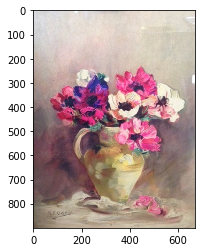

Caption: christmas tree branch on a wooden background


In [ ]:
index=79
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/content/content/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))


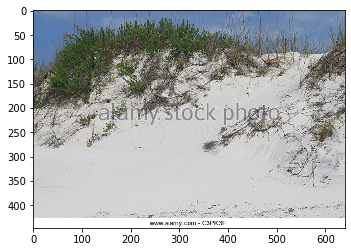

Caption: a tree shows its


In [ ]:
index=90
image_file=data.iloc[index,2]

image=encoded_images[int(image_file.split('.')[0])]

image = image.reshape((1,OUTPUT_DIM))
x=plt.imread('/content/content/images/'+image_file)
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))
